<a href="https://www.kaggle.com/code/antonkoltsov/anton-koltsov-copy-baseline-v1?scriptVersionId=134134500" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [131]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#импортируем библиотеки нормализации
from sklearn import preprocessing

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [132]:
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [133]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [134]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [135]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [136]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [137]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


 Рассмотрим данные на примере пары записей:
1. hotel_address -можно попробовать извлечь город и страну.
2. additional_number_of_scoring-бросается в глаза , что размерность этого столбца измеряется в сотнях и возможно логнормально. Проверим позже.
3.review_date-пока не знаю как использовать.Посмотрим есть ли смысл извлечь год или квартал.
4.average_score-целевой признак.
5.hotel_name-пока не знаю как использовать.
6.reviewer_nationality-попробуем закодировать признак . Возможно это улучшит модель.
7.negative_review-это что-то типа краткого негативного комментария
8.review_total_negative_word_counts	-количество негативных слов в комментарии. Может пригодится.
9.total_number_of_reviews-общее число обзоров отеля
10.positive_review-это что-то типа краткого поситивного комментария                            
11.review_total_positive_word_counts-количество положительных слов в комментарии. Может пригодится
12.total_number_of_reviews_reviewer_has_given-количество отзывов данного обозревателя
13.reviewer_score-сколько балов поставлено в данном обзоре
14.tags-теги
15.days_since_review-сколько дней прошло с даты ревью.
16.lat-широта места где находится отель
17.lng-широта места где находится отель


In [138]:
#c
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [139]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [140]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [141]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [142]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [143]:
#смотрим наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [144]:
'''Пока заполним их нулями. Предполагаю , что ширина и долгота не сильно помогут 
в предсказаниях если их как минимум не группировать или кодировать'''
data['lat'].fillna(0, inplace=True)
data['lng'].fillna(0, inplace=True)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0


In [145]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0


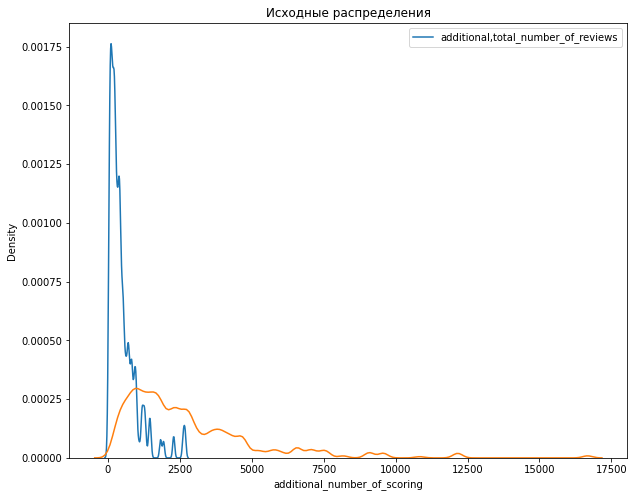

In [146]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data['additional_number_of_scoring'], ax=ax1, label ='additional,total_number_of_reviews')
sns.kdeplot(data['total_number_of_reviews'], ax=ax1)


plt.legend()
data.head(2)


Предположим , что мы имеем дело с логнормальным распределением 'additional_number_of_scoring' и 'total_number_of_reviews'

In [147]:
#Функция поиска отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [148]:
#Удалим отклонения-удаление отклонений снижает метрику MAPE на 0,02 поэтому этот код закомментирован
'''outliers, cleaned = outliers_z_score(data[data['sample']==1], 'total_number_of_reviews', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


while outliers.shape[0]>0:
 outliers, cleaned = outliers_z_score(data[data['sample']==1], 'total_number_of_reviews', log_scale=True)
 data=data.drop(outliers.index)
 print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
 print(f'Результирующее число записей: {cleaned.shape[0]}')'''



"outliers, cleaned = outliers_z_score(data[data['sample']==1], 'total_number_of_reviews', log_scale=True)\nprint(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')\nprint(f'Результирующее число записей: {cleaned.shape[0]}')\n\n\nwhile outliers.shape[0]>0:\n outliers, cleaned = outliers_z_score(data[data['sample']==1], 'total_number_of_reviews', log_scale=True)\n data=data.drop(outliers.index)\n print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')\n print(f'Результирующее число записей: {cleaned.shape[0]}')"

In [149]:
'''#Удалим отклонения
outliers, cleaned = outliers_z_score(data[data['sample']==1], 'additional_number_of_scoring', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


while outliers.shape[0]>0:
 outliers, cleaned = outliers_z_score(data[data['sample']==1], 'additional_number_of_scoring', log_scale=True)
 data=data.drop(outliers.index)
 print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
 print(f'Результирующее число записей: {cleaned.shape[0]}')'''


"#Удалим отклонения\noutliers, cleaned = outliers_z_score(data[data['sample']==1], 'additional_number_of_scoring', log_scale=True)\nprint(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')\nprint(f'Результирующее число записей: {cleaned.shape[0]}')\n\n\nwhile outliers.shape[0]>0:\n outliers, cleaned = outliers_z_score(data[data['sample']==1], 'additional_number_of_scoring', log_scale=True)\n data=data.drop(outliers.index)\n print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')\n print(f'Результирующее число записей: {cleaned.shape[0]}')"

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


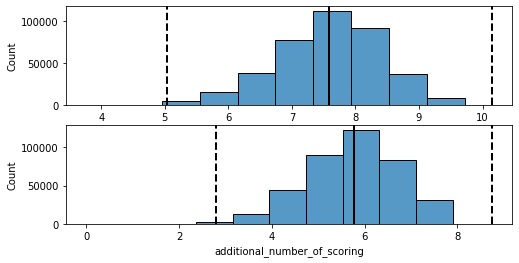

In [150]:
#кажется количество обзоров и количество дополнительных очков распределены логнормально
#построим графики чтобы посмотреть это

fig, axes = plt.subplots(2, figsize=(8, 4))
number_of_review = np.log(data[data['sample']==1]['total_number_of_reviews'])
additional_number_of_scoring= np.log(data[data['sample']==1]['additional_number_of_scoring'])
review_total_negative_word_counts= np.log(data[data['sample']==1]['review_total_negative_word_counts'])
histplot = sns.histplot(number_of_review, bins=10, ax=axes[0])

#Добавим линии 3х сигм чтобы графически убедится что отклонения удалены
histplot.axvline(number_of_review.mean(), color='k', lw=2)
histplot.axvline(number_of_review.mean()+ 3 * number_of_review.std(), color='k', ls='--', lw=2)
histplot.axvline(number_of_review.mean()- 3 * number_of_review.std(), color='k', ls='--', lw=2)


histplot = sns.histplot(additional_number_of_scoring, bins=10, ax=axes[1])

histplot.axvline(additional_number_of_scoring.mean(), color='k', lw=2)
histplot.axvline(additional_number_of_scoring.mean()+ 3 * additional_number_of_scoring.std(), color='k', ls='--', lw=2)
histplot.axvline(additional_number_of_scoring.mean()- 3 * additional_number_of_scoring.std(), color='k', ls='--', lw=2)



#Распределение на графике выглядит нормально-распределенным

In [151]:
# Выделим лограифмированные значения в отдельные столбцы
data['total_number_of_reviews_log']=np.log(data['total_number_of_reviews'])
data['additional_number_of_scoring_log']=np.log(data['additional_number_of_scoring'])

#После сабмита это преообразование улучшило MAPE На 0.05

In [152]:
#удалим ставшие не нужными колонки которые искажают масштаб
data.drop(['total_number_of_reviews','additional_number_of_scoring'], axis = 1, inplace=True)

In [153]:
#Выделим количество дней после ревью в отдельный признак.

data['days_since_review_num']=data['days_since_review'].apply(lambda x: int(x.split(' ')[-2]))

In [154]:
data['days_since_review_num']#Проверка что выделили верно

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review_num, Length: 515738, dtype: int64

In [155]:
data.head(2)


,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,total_number_of_reviews_log,additional_number_of_scoring_log,days_since_review_num
0,Via Senigallia 6 20161 Milan Italy,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,9.721366,6.806829,13
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,8.520787,6.416732,234


In [156]:
''''Предположим , что национальность ревьюера влияет на оценку. 
Посчитаем количество разных национальностей и рассмотрим возможность их закодировать.'''
data['reviewer_nationality'].nunique()
#униакальных нацональностей 227
#Посмотрим самое большое число национальностей
data['reviewer_nationality'].value_counts(normalize=True).head(15)

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
 Saudi Arabia                 0.017356
 Netherlands                  0.017009
 Switzerland                  0.016826
 Germany                      0.015397
 Canada                       0.015306
 France                       0.014147
 Israel                       0.012817
 Italy                        0.011855
 Belgium                      0.011694
 Turkey                       0.010556
Name: reviewer_nationality, dtype: float64

In [157]:
#Попробуем разделить национальность на англичан и всех остальных так как на отзывы англичан приходится половина отзывов
data.loc[data['reviewer_nationality'].str.contains('United Kingdom'),'UK_Review']=1

In [158]:
data['UK_Review'].fillna(0,inplace=True)
data['UK_Review']

0         1.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
515733    0.0
515734    0.0
515735    0.0
515736    0.0
515737    0.0
Name: UK_Review, Length: 515738, dtype: float64

In [159]:
#Выделим страну предположив ,что это влияющий признак
data['country']=data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['country'].nunique()
data['country'].unique()
#Оказалось всего 6 уникальных стран


array(['Italy', 'Netherlands', 'Spain', 'Kingdom', 'France', 'Austria'],
      dtype=object)

In [160]:
#Закодируем страны и посмотрим будет ли страна нахождения отеля влиять на отзывы.
data = pd.get_dummies(data, columns = ['country'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [161]:
data['city']=data['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-1]!='Kingdom' else x.split(' ')[-5] )

data['city'].nunique()
data['city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [162]:
data = pd.get_dummies(data, columns = ['city'])

In [163]:
#если городов всего 6 предположим , что широта и долгота не играют решающей роли и удалим их
data.drop(['lat','lng'], axis = 1, inplace=True)

Просмотрим на на распредедение Тегов

In [164]:
#подсчет количества уникальных тегов


from collections import Counter
# счетчик для подсчета количества тегов
s1=Counter()

#Функция для очистки поля с тегами из датафрейма и добавления уникальныхх тегов в счетчик(каунтер)
def tags_to_list(tags_row):
 r1=tags_row.replace("[","")
 r2=r1.replace("]","")
 
 for i in r2.split(sep=","):
     i2=i.replace("' ","")
     i3=i2.replace(" '","")
     i4=i3.lstrip()
     s1.update({i4:1})  
     pass


data['tags_n']=data['tags'].apply(tags_to_list)
display(s1.most_common(10))
total = sum(s1.values(), 0.0)
for key in s1:
    s1[key] /= total
display(s1.most_common(10))

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015)]

[('Leisure trip', 0.17728058144982245),
 ('Submitted from a mobile device', 0.13054444723566913),
 ('Couple', 0.10705883750772302),
 ('Stayed 1 night', 0.0821716275027667),
 ('Stayed 2 nights', 0.0568350397523203),
 ('Solo traveler', 0.04606015805875603),
 ('Stayed 3 nights', 0.04066083564740948),
 ('Business trip', 0.03519446726459226),
 ('Group', 0.027748545357024042),
 ('Family with young children', 0.025891202210649954)]

выделим несколько самых популярных тегов в отдельные столбцы и оценим их влияние.Например могу предположить ,что Leisure trip может улучшать отзыв т.к. это отзыв об отдыхе.

In [165]:
data.loc[data['tags'].str.contains('Leisure trip'),'Leisure_trip']=1
data.loc[data['tags'].str.contains('Submitted from a mobile device'),'Mobile_Submit']=1
data.loc[data['tags'].str.contains('Couple'),'Couple']=1
data['Leisure_trip'].fillna(0,inplace=True)
data['Leisure_trip']
data['Mobile_Submit'].fillna(0,inplace=True)
data['Mobile_Submit']
data['Couple'].fillna(0,inplace=True)
data['Couple']

0         1.0
1         0.0
2         0.0
3         1.0
4         0.0
         ... 
515733    0.0
515734    1.0
515735    0.0
515736    0.0
515737    1.0
Name: Couple, Length: 515738, dtype: float64

In [166]:
#Посмотрим на самые популярные комментарии в негативных и позитивных комментариях
data['negative_review'].str.strip()
print(data['negative_review'].value_counts(ascending=False).head(50))
data['positive_review'].str.strip()
print(data['positive_review'].value_counts(ascending=False).head(50))
#составим список наиболее часто встречающихя комментариев , которые помогают определить 
#Негативный комментарий или позитивный
positive_list=['No Negative','Nothing','N A','None','N a','All good',\
               'Nothing really','none','nothing','No complaints','Nothing really'\
              'Nil','n a','Nothing at all','Nothing to dislike','Nothing to dislike'\
              'Nothing at all','All good','NA','Can t think of anything','Absolutely nothing'\
              'Everything was perfect','No','Nothing to dislike','Everything was perfect'\
              'Everything was great ','Nothing to complain about','Leaving','NOTHING','Having to leave'\
              ]
negative_list=['No Positive','Nothing','nothing']

data['is_positive'] = data['positive_review'].apply(lambda x: 0 if x in negative_list else 1)
data['is_negative'] = data['negative_review'].apply(lambda x: 0 if x in positive_list else 1)

No Negative                    127890
 Nothing                        14295
 Nothing                         4236
 nothing                         2225
 N A                             1037
 None                             984
                                  849
 N a                              509
 Breakfast                        407
 Small room                       373
 Location                         368
 Everything                       326
 All good                         318
 Nothing really                   316
 none                             302
 nothing                          283
 No complaints                    274
 Price                            260
 Nothing really                   254
 Nil                              247
 n a                              227
 Nothing at all                   221
 Nothing to dislike               209
 Nothing at all                   194
 Small rooms                      188
 None                             182
 No complain

In [167]:
#сделаем маркеры наличия хороших и плохих слов

#data['words_negative']=data['review_total_negative_word_counts'].apply(lambda x:0 if x==0 else 1)
#data['words_positive']=data['review_total_positive_word_counts'].apply(lambda x:0 if x==0 else 1)

<AxesSubplot:>

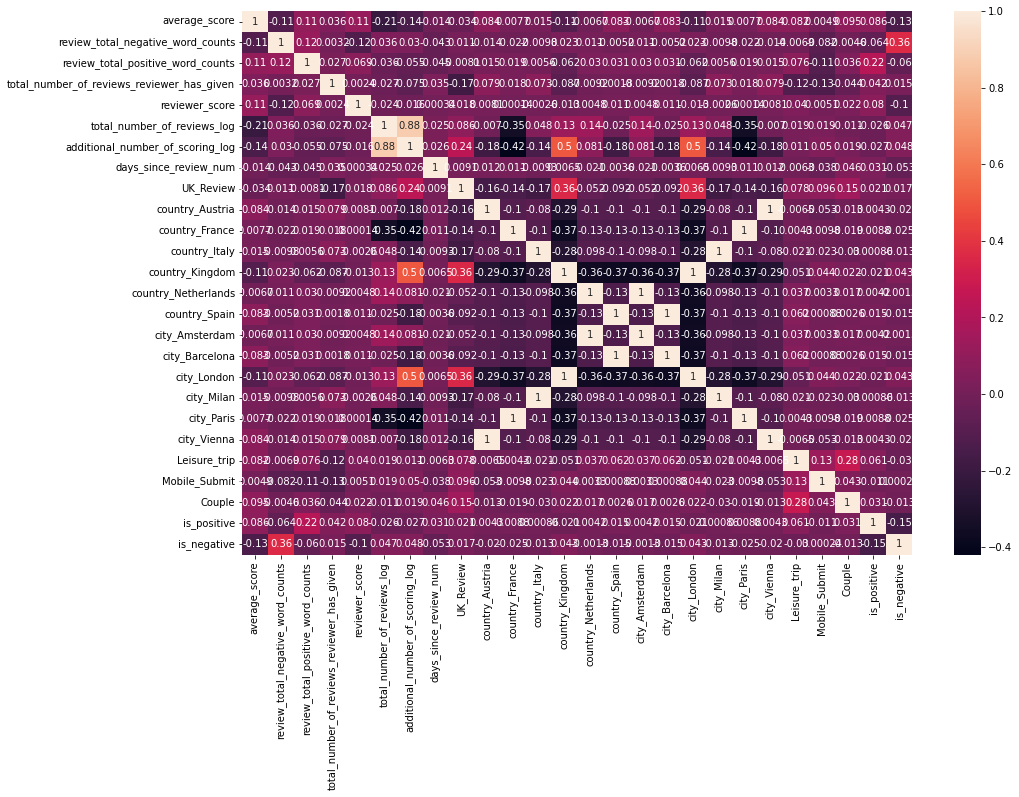

In [168]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [169]:
data.head(2)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,city_London,city_Milan,city_Paris,city_Vienna,tags_n,Leisure_trip,Mobile_Submit,Couple,is_positive,is_negative
0,Via Senigallia 6 20161 Milan Italy,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,...,0,1,0,0,None,1.0,0.0,1.0,1,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,No Positive,0,7,...,0,0,0,0,None,1.0,0.0,0.0,0,1


In [170]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns
data.drop(object_columns, axis = 1, inplace=True)


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   sample                                      515738 non-null  int64  
 5   reviewer_score                              515738 non-null  float64
 6   total_number_of_reviews_log                 515738 non-null  float64
 7   additional_number_of_scoring_log            515738 non-null  float64
 8   days_since_review_num                       515738 non-null  int64  
 9   UK_Review                                   515738 non-null  float64
 

In [172]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [173]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [174]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 26), (386803, 26), (386803, 25), (309442, 25), (77361, 25))

In [175]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [176]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [177]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [178]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
#print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))*100

MAE: 0.9463846301600226


<AxesSubplot:>

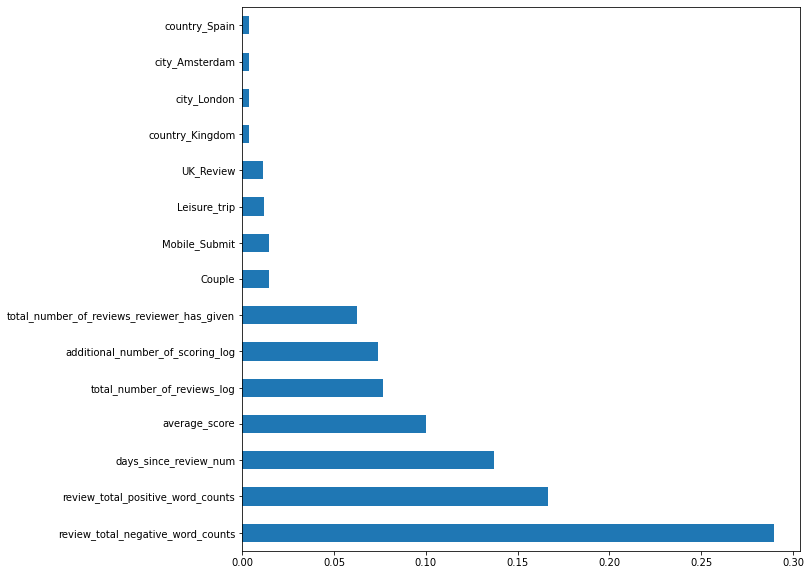

In [179]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [180]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,total_number_of_reviews_log,additional_number_of_scoring_log,days_since_review_num,UK_Review,country_Austria,...,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,Leisure_trip,Mobile_Submit,Couple,is_positive,is_negative
123985,8.7,38,4,1,0.0,7.216709,5.442418,368,1.0,0,...,0,1,0,0,0,1.0,1.0,1.0,1,1
59628,8.3,60,0,1,0.0,7.378384,5.147494,490,0.0,0,...,1,0,0,0,0,1.0,0.0,0.0,0,1
64347,7.7,22,10,3,0.0,7.462215,5.147494,138,0.0,0,...,0,0,1,0,0,1.0,1.0,0.0,1,1
92692,8.5,67,22,3,0.0,6.381816,4.060443,709,1.0,0,...,1,0,0,0,0,1.0,1.0,0.0,1,1
81129,8.1,14,48,5,0.0,7.017506,5.389072,343,0.0,0,...,0,1,0,0,0,1.0,1.0,0.0,1,1
165,8.3,13,33,1,0.0,7.771489,5.468060,172,0.0,0,...,1,0,0,0,0,0.0,0.0,0.0,1,1
38639,8.1,4,22,6,0.0,8.568836,5.594711,672,0.0,0,...,0,0,1,0,0,1.0,1.0,0.0,1,1
112939,7.9,20,9,1,0.0,6.890609,4.983607,143,0.0,0,...,0,0,0,1,0,0.0,0.0,1.0,1,1
110012,8.5,8,6,3,0.0,7.876638,6.669498,331,1.0,0,...,0,1,0,0,0,1.0,1.0,0.0,1,1
98690,8.6,21,4,1,0.0,7.960324,6.200509,179,1.0,0,...,0,0,0,0,0,1.0,1.0,0.0,1,1


In [181]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [182]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [183]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [184]:
predict_submission

array([8.544, 7.272, 7.966, ..., 7.923, 9.618, 7.245])

In [185]:
list(sample_submission)

['reviewer_score', 'id']

In [186]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.544,488440
1,7.272,274649
2,7.966,374688
3,9.699,404352
4,9.480,451596
5,8.276,302161
6,8.183,317079
7,7.696,13963
8,8.593,159785
9,7.961,195089
